In [1]:
# import pakietów i ustawienia notebooka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import mahotas

from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
#ustawienie jednego rozmiaru dla wszystkich plików
for filename in glob.iglob('*.jpg'):
    im = Image.open(filename)
    imResize = im.resize((112,112), Image.ANTIALIAS)
    imResize.save(filename , 'JPEG', quality=90)

In [8]:
# lista plików z kotami
cats_list = []
for filename in glob.glob('train/cat/*.jpg'):
    im = Image.open(filename)
    cats_list.append(im)

In [2]:
#lista plików z psami
dogs_list = []
for filename in glob.glob('train/dog/*.jpg'):
    im = Image.open(filename)
    dogs_list.append(im)

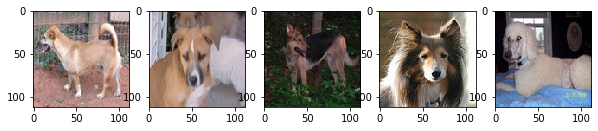

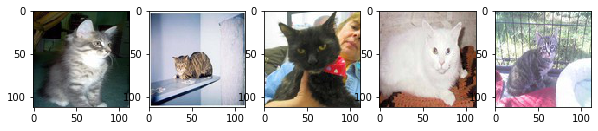

In [7]:
# jak widać może nie być łatwo! :)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (10,10))
im1 = ax1.imshow(np.asarray(dogs_list[1]));
im2 = ax2.imshow(np.asarray(dogs_list[2]));
im3 = ax3.imshow(np.asarray(dogs_list[11]));
im4 = ax4.imshow(np.asarray(dogs_list[5]));
im5 = ax5.imshow(np.asarray(dogs_list[6]));

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (10,10))
im1 = ax1.imshow(np.asarray(cats_list[1]));
im2 = ax2.imshow(np.asarray(cats_list[2]));
im3 = ax3.imshow(np.asarray(cats_list[0]));
im4 = ax4.imshow(np.asarray(cats_list[16]));
im5 = ax5.imshow(np.asarray(cats_list[6]));

In [11]:
# budowa funkcji wyciągających cechy obrazu

# intensywność i położenie pikseli
def fd_hu_moments(image):
    image = np.asarray(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# tekstura, ile razy piksele przyjmuje jakąś wartośc obok innego piksela o jakiejś wartości
def fd_haralick(image):
    image = np.asarray(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# histogram kolorów obrazu, na razie po 5 słupków dla każdego kanału
def fd_histogram(image, mask=None):
    image = np.asarray(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [5, 5, 5],[0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [12]:
# tabela z danymi o obrazach kotów
cats_frame = pd.DataFrame()                                   
for cat in cats_list:
    fv_hu_moments = fd_hu_moments(cat)
    fv_haralick   = fd_haralick(cat)
    fv_histogram  = fd_histogram(cat)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    df = pd.DataFrame(data=global_feature.flatten())
    df = df.transpose()
    cats_frame = cats_frame.append(df, ignore_index = True)
    
cats_frame

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144
0,0.082983,0.034518,0.076358,0.039051,0.466168,0.020223,0.014993,0.043932,0.078799,0.178866,0.004184,0.002092,0.008019,0.037656,0.064852,0.004533,0.000000,0.001046,0.005579,0.003487,0.002789,0.000000,0.000000,0.000000,0.000000,0.563446,0.402362,0.118198,0.053695,0.150624,0.189326,0.260454,0.104949,0.035564,0.081239,0.039748,0.035913,0.024407,0.046721,0.025801,0.005927,0.005579,0.008717,0.003835,0.000349,0.001743,0.000697,0.002092,0.000349,0.000000,0.036610,0.024407,0.003138,0.019874,0.051951,0.046721,0.040794,0.012203,0.017782,0.094489,0.021617,0.055089,0.097278,0.145394,0.067293,0.006973,0.013598,0.071477,0.089607,0.026847,0.002092,0.002441,0.005579,0.028591,0.019874,0.005927,0.002789,0.001395,0.000697,0.020571,0.004533,0.002441,0.000000,0.000000,0.000000,0.001743,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000392,383.387306,0.967532,5904.825481,0.175971,229.214946,23235.914619,8.696929,12.487123,0.000210,4.831647,-0.380473,0.998533,0.001684,1.497145e-08,1.080355e-10,1.385653e-10,-1.689793e-20,-1.572196e-14,-1.374246e-21
1,0.122637,0.248755,0.430582,0.248755,0.182601,0.189565,0.298661,0.011219,0.000000,0.000000,0.354370,0.200397,0.000000,0.000000,0.000000,0.088206,0.001161,0.000000,0.000000,0.000000,0.008124,0.000000,0.000000,0.000000,0.000000,0.043329,0.039847,0.104454,0.200784,0.214711,0.193820,0.100585,0.000000,0.000000,0.000000,0.302143,0.116834,0.000000,0.000000,0.000000,0.136564,0.080855,0.000000,0.000000,0.000000,0.096717,0.025146,0.000000,0.000000,0.000000,0.035979,0.096330,0.115673,0.098651,0.059964,0.045263,0.008898,0.000000,0.000000,0.000000,0.034044,0.005416,0.000000,0.000000,0.000000,0.042168,0.005416,0.000000,0.000000,0.000000,0.073505,0.007350,0.000000,0.000000,0.000000,0.017022,0.069636,0.027081,0.007737,0.013927,0.010445,0.000000,0.000000,0.000000,0.000000,0.001547,0.000000,0.000000,0.000000,0.0,0.006190,0.000000,0.000000,0.0,0.0,0.029789,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000407,241.316881,0.974340,4699.917011,0.196220,175.043076,18558.351163,8.633615,12.303946,0.000240,4.584817,-0.393757,0.998751,0.001324,7.563237e-08,4.755066e-11,3.219892e-11,-1.097522e-21,-3.876378e-15,6.187268e-22
2,0.000709,0.001949,0.023738,0.306110,0.836135,0.000709,0.010097,0.065190,0.247652,0.010983,0.001417,0.012755,0.020372,0.004429,0.000000,0.004074,0.009035,0.000886,0.000000,0.000000,0.015058,0.003543,0.000000,0.000000,0.000000,0.000354,0.001417,0.003897,0.001771,0.023029,0.000177,0.001063,0.001594,0.001063,0.000709,0.000177,0.000354,0.001949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000531,0.000000,0.000000,0.000000,0.000000,0.000709,0.012755,0.019486,0.015235,0.021258,0.001594,0.010452,0.051904,0.041098,0.007086,0.000886,0.002480,0.007440,0.001594,0.000000,0.000354,0.000177,0.000000,0.000000,0.000000,0.000354,0.000000,0.000000,0.000000,0.000000,0.000709,0.003720,0.003720,0.035961,0.363506,0.001417,0.000531,0.000000,0.000000,0.000000,0.000886,0.000177,0.000000,0.000000,0.0,0.001771,0.000177,0.000000,0.0,0.0,0.001771,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000775,624.240774,0.869034,2385.915312,0.267960,370.700043,8919.420472,8.250832,11.659663,0.000339,4.531603,-0.402954,0.998436,0.000877,7.045676e-10,2.758907

In [ ]:
# tabela z danymi o obrazach z psami
dogs_frame = pd.DataFrame()                                   
for dog in dogs_list:
    fv_hu_moments = fd_hu_moments(dog)
    fv_haralick   = fd_haralick(dog)
    fv_histogram  = fd_histogram(dog)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    df = pd.DataFrame(data=global_feature.flatten())
    df = df.transpose()
    dogs_frame = dogs_frame.append(df, ignore_index = True)

In [13]:
#cat = pd.read_csv('cat')
#cat1 = pd.read_csv('cat1')
#dog = pd.read_csv('dog')
#dog1 = pd.read_csv('dog1')

#cats = cat.append(cat1, ignore_index = True)
#dogs = dog.append(dog1, ignore_index = True)

In [4]:
# dodanie kolumny z kategorią gatunku do tabel
cats['gatunek'] = 0
dogs['gatunek'] = 1

In [5]:
# połączenie tabel w jedną
frame = cats.append(dogs, ignore_index = True)
frame = frame.drop(columns=['Unnamed: 0'])
frame.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,gatunek
0,0.481527,0.001684,0.000337,0.000000,0.004041,0.098999,0.000000,0.000000,0.000000,0.00000,0.036030,0.000000,0.000000,0.000000,0.0,0.007408,0.000000,0.0,0.0,0.0,0.007071,0.0,0.0,0.0,0.0,0.020204,0.015490,0.017847,0.020541,0.031990,0.100683,0.048826,0.031316,0.024581,0.002694,0.058591,0.189243,0.009765,0.000000,0.000000,0.088560,0.019530,0.000000,0.000000,0.0,0.023234,0.000337,0.00000,0.0,0.0,0.032326,0.029632,0.081489,0.143111,0.158601,0.137050,0.221233,0.260967,0.164325,0.054887,0.276120,0.088897,0.022898,0.002020,0.000000,0.305416,0.053877,0.008082,0.000000,0.0,0.246488,0.475129,0.035357,0.0,0.0,0.000337,0.000000,0.000000,0.000673,0.001347,0.024581,0.000000,0.000000,0.000000,0.00000,0.054214,0.000000,0.0,0.0,0.0,0.003704,0.0,0.0,0.0,0.0,0.000673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010320,545.331541,0.927216,3744.234723,0.298376,107.975138,14431.607351,7.539564,10.816668,0.000310,4.707757,-0.368878,0.996036,0.002174,1.617993e-07,4.194349e-10,3.185629e-10,1.064954e-19,-1.251305e-13,-4.710027e-20,0
1,0.488115,0.021545,0.007417,0.010949,0.017660,0.052979,0.001766,0.000353,0.000000,0.00000,0.006711,0.000000,0.000000,0.000000,0.0,0.001060,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.217921,0.012362,0.018013,0.046269,0.021192,0.190019,0.015894,0.021545,0.011302,0.000353,0.038145,0.023664,0.287854,0.076643,0.000000,0.013068,0.026136,0.166355,0.000353,0.0,0.004592,0.000706,0.00106,0.0,0.0,0.404055,0.098188,0.049094,0.238053,0.298096,0.301981,0.030022,0.045209,0.170593,0.091831,0.052273,0.039205,0.083354,0.012362,0.001766,0.018719,0.040971,0.137393,0.000000,0.0,0.006004,0.000353,0.000000,0.0,0.0,0.207678,0.074524,0.048741,0.021545,0.005651,0.119733,0.015187,0.002119,0.000000,0.00000,0.013068,0.000000,0.0,0.0,0.0,0.000353,0.0,0.0,0.0,0.0,0.000353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000626,344.610272,0.957329,4039.689606,0.196977,150.127245,15814.148152,8.222036,11.908179,0.000259,4.644519,-0.359786,0.997183,0.002433,2.306662e-07,8.649352e-10,7.453195e-10,5.862166e-19,1.014988e-13,-1.202318e-19,0
2,0.000798,0.135035,0.042286,0.037299,0.000000,0.000598,0.000199,0.000000,0.000000,0.00000,0.000399,0.000199,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.008178,0.439810,0.152388,0.040291,0.000000,0.001995,0.782682,0.004388,0.000000,0.000000,0.000399,0.000598,0.000000,0.000000,0.000000,0.000199,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.081978,0.227983,0.055051,0.000000,0.000000,0.091153,0.230975,0.155579,0.000000,0.000000,0.004588,0.000598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.001995,0.001795,0.002593,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001981,108.991376,0.950213,1094.452216,0.305729,175.335294,4268.817487,7.591136,10.890255,0.000475,4.085234,-0.355682,0.995233,0.001662,1.945067e-08,1.356021e-11,3.411949e-11,-7.208004e-22,3.902926e-15,1.380450e-22,0
3,0.038142,0.081820,0.102429,0.090125,0.464467,0.093509,0.184864,0.093816,0.180558,0.00769,0.022762,0.009228,0.002153,0.000308,0.0,0.004922,0.001538,0.0,0.0,0.0,0.004614,0.0,0.0,0.0,0.0,0.006152,0.014149,0.018148,0.016918,0.697008,0.006152

In [6]:
frame.shape

(20000, 146)

In [5]:
# podział zbioru na treningowy i testowy
X = frame.drop('gatunek', axis = 1)
y = pd.DataFrame(frame['gatunek'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [9]:
y_test['gatunek'].value_counts()

1    2015
0    1985
Name: gatunek, dtype: int64

In [35]:
y_train['gatunek'].value_counts()

0    8015
1    7985
Name: gatunek, dtype: int64

In [6]:
# teraz wyuczę różne algorytmy klasyfikujące

# Klasyfikator las losowy
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

# Regresja logistyczna
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)

# Klasyfikator k - najbliższych sasiadów
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train)  
acc_knn = round(knn.score(X_train, y_train) * 100, 2)

# Maszyna wektorów nośnych
svc = SVC()
svc.fit(X_train, y_train)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)


# zebranie wyników dla zbioru treningowego w jeden obiekt dataframe
wyniki = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest]})
wyniki_df = wyniki.sort_values(by='Score', ascending=False)
wyniki_df = wyniki_df.set_index('Score')
wyniki_df.head(4)

,Model
Score,
99.91,Support Vector Machines
98.70,Random Forest
72.08,KNN
63.74,Logistic Regression


In [8]:
# przetrenowane te nasze algorytmy jak NRDowska pływaczka, sprawdźmy jak sobie radzą sobie na zbiorze testowym
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)

acc_log = round(logreg.score(X_test, y_test) * 100, 2)

acc_knn = round(knn.score(X_test, y_test) * 100, 2)

acc_svc = round(svc.score(X_test, y_test) * 100, 2)


# zebranie wyników dla zbioru treningowego w jeden obiekt dataframe
wyniki = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest]})
wyniki_df = wyniki.sort_values(by='Score', ascending=False)
wyniki_df = wyniki_df.set_index('Score')
wyniki_df.head(4)

,Model
Score,
64.98,Random Forest
63.12,Logistic Regression
58.32,KNN
50.48,Support Vector Machines


In [7]:
# no i faktycznie. wyniki sa dużo słabsze, spróbujmy przeszukać siatkę parametrów dla wybranych algorytmów

# najpierw las losowy

#liczba drzew w lesie
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# liczba cech do rozważenia przy każdym podziale
max_features = ['auto', 'sqrt']
# maksymalna liczba poziomów w każdym drzewie
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimalna liczba cech przy każdym podziale
min_samples_leaf = [1, 2, 5, 10]
# Metoda wyboru przykładów do trenowania każdego drzewa
bootstrap = [True, False]

# Utworzenie siatki do losowego przeszukania
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25,
                               cv = 3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 24.2min finished


{'n_estimators': 900,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [8]:
# teraz najblizszi sasiedzi
grid = {'n_neighbors': [3,5,10,20,50,100], 
        'weights' : ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
        }
 
knn = KNeighborsClassifier() 
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = grid, n_iter = 25,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
knn_random.fit(X_train, y_train)

knn_random.best_params_ 


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.5min finished


{'weights': 'distance', 'n_neighbors': 100, 'metric': 'manhattan'}

In [9]:
# regresja logistyczna
grid = {"C":np.logspace(-4,4,9), 
        "penalty":["l1","l2"],
        'tol' : [0.0001, 0.001, 0.01, 1]
       }
 
log_reg = LogisticRegression()
log_reg_random = RandomizedSearchCV(estimator = log_reg, param_distributions = grid, n_iter = 25,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
log_reg_random.fit(X_train, y_train)

log_reg_random.best_params_ 

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   38.7s finished


{'tol': 0.0001, 'penalty': 'l1', 'C': 1000.0}

In [10]:
# wskaźniki dla lasu losowego dla optymalnych parametrów
rf = RandomForestClassifier(n_estimators = 900, bootstrap = False, min_samples_leaf = 2, max_features = 'auto', max_depth = 40)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1410  575]
 [ 621 1394]]

Accuracy:  70.1


In [11]:
# wskaźniki dla regresji logistycznej
log_reg = LogisticRegression(tol = 0.0001, penalty = 'l1', C =1000)
log_reg.fit(X_train, y_train)
pred = log_reg.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1314  671]
 [ 725 1290]]

Accuracy:  65.1


In [12]:
# wskaźniki dla k najbliższych sąsiadów
knn = KNeighborsClassifier(weights = 'distance', n_neighbors = 100, metric = 'manhattan' ) 
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1207  778]
 [ 762 1253]]

Accuracy:  61.5


In [3]:
# spróbujmy teraz zwiększyć liczbę słupków w histogramach w celu zwiększenia liczby cech

def fd_hu_moments(image):
    image = np.asarray(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    image = np.asarray(image)
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

def fd_histogram(image, mask=None):
    image = np.asarray(image)
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [10, 10, 10],[0, 256, 0, 256, 0, 256])
    # normalize the histogram00
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [19]:
# lista plików z kotami
cats_list = []
for filename in glob.glob('train/cat/*.jpg'):
    im = Image.open(filename)
    cats_list.append(im)

cats_frame = pd.DataFrame()                                   
for cat in cats_list:
    fv_hu_moments = fd_hu_moments(cat)
    fv_haralick   = fd_haralick(cat)
    fv_histogram  = fd_histogram(cat)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    df = pd.DataFrame(data=global_feature.flatten())
    df = df.transpose()
    cats_frame = cats_frame.append(df, ignore_index = True)
    

#cats_frame.to_csv('cats100', index = False)

In [21]:
#lista plików z psami
dogs_list = []
for filename in glob.glob('train/dog/*.jpg'):
    im = Image.open(filename)
    dogs_list.append(im)

dogs_frame = pd.DataFrame()                                   
for dog in dogs_list:
    fv_hu_moments = fd_hu_moments(dog)
    fv_haralick   = fd_haralick(dog)
    fv_histogram  = fd_histogram(dog)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    df = pd.DataFrame(data=global_feature.flatten())
    df = df.transpose()
    dogs_frame = dogs_frame.append(df, ignore_index = True)
    
#dogs_frame.to_csv('dogs100', index = False)

In [7]:
#cat = pd.read_csv('cats100')
#cat1 = pd.read_csv('cats101')
#dog = pd.read_csv('dogs100')
#dog1 = pd.read_csv('dogs101')

#cats = cat.append(cat1, ignore_index = True)
#dogs = dog.append(dog1, ignore_index = True)

cats['gatunek'] = 0
dogs['gatunek'] = 1

frame = cats.append(dogs, ignore_index = True)
frame.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,gatunek
0

In [8]:
# skalowanie cech z tabeli
X = frame.drop('gatunek', axis = 1)
y = pd.DataFrame(frame['gatunek'])

X_scaled = StandardScaler().fit_transform(X.values)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [43]:
X_scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019
0,5.53591

In [45]:
X_scaled_df.describe()

0             1             2             3             4  \
count  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04   
mean   4.342893e-15 -2.196889e-15  7.393891e-16  3.378409e-17  2.477796e-16   
std    1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   
min   -3.161031e-01 -3.909258e-01 -4.320606e-01 -4.497954e-01 -4.558105e-01   
25%   -3.161031e-01 -3.850039e-01 -4.225984e-01 -4.379645e-01 -4.441974e-01   
50%   -3.022914e-01 -3.312502e-01 -3.468912e-01 -3.545213e-01 -3.538422e-01   
75%   -1.874277e-01 -9.501094e-02 -5.254761e-02 -3.634029e-02 -3.300028e-02   
max    8.900068e+00  1.342566e+01  1.557945e+01  1.466392e+01  1.317012e+01   

                  5             6             7             8             9  \
count  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04   
mean   3.310019e-16 -2.608330e-16  9.618140e-16 -9.072104e-16 -1.377015e-15   
std    1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   
min   -4.724015e-01 -4.858765e-01 -4.844705e-01 -4.545983e-01 -4.611383e-01   
25%   -4.620212e-01 -4.780940e-01 -4.798955e-01 -4.545983e-01 -4.611383e-01   
50%   -3.670145e-01 -3.854117e-01 -3.971299e-01 -3.916780e-01 -4.240895e-01   
75%   -1.921560e-02 -4.249612e-03 -1.434850e-02 -3.910250e-02 -8.688307e-02   
max    1.138402e+01  1.036218e+01  1.039089e+01  9.600316e+00  5.924164e+00   

                 10            11            12            13            14  \
count  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04   
mean   2.169200e-15 -1.963885e-15  1.949808e-15  3.882131e-16  2.374893e-15   
std    1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   
min   -3.172515e-01 -4.214586e-01 -4.190369e-01 -4.401180e-01 -4.161842e-01   
25%   -3.172515e-01 -4.214586e-01 -4.190369e-01 -4.401180e-01 -4.161842e-01   
50%   -2.944548e-01 -3.506831e-01 -3.492006e-01 -3.655775e-01 -3.545993e-01   
75%   -1.051418e-01 -5.887487e-02 -5.815660e-02 -4.959407e-02 -6.182613e-02   
max    2.391898e+01  1.529630e+01  1.738149e+01  1.543854e+01  1.499468e+01   

                 15            16            17            18            19  \
count  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04   
mean  -1.042871e-15  9.750950e-16  6.905032e-16 -6.487005e-16 -1.129206e-15   
std    1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   
min   -4.078452e-01 -3.725900e-01 -3.375174e-01 -3.065760e-01 -2.374400e-01   
25%   -4.078452e-01 -3.725900e-01 -3.375174e-01 -3.065760e-01 -2.374400e-01   
50%   -3.583193e-01 -3.443055e-01 -3.257101e-01 -3.065760e-01 -2.374400e-01   
75%   -8.021047e-02 -1.108733e-01 -1.458085e-01 -1.857401e-01 -1.992255e-01   
max    1.413130e+01  1.417743e+01  1.437932e+01  1.660696e+01  1.787422e+01   

                 20            21            22            23            24  \
count  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04   
mean   1.246272e-15  3.966262e-15  3.044079e-15  2.348638e-15  4.395911e-15   
std    1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   
min   -3.178030e-01 -3.655391e-01 -3.608874e-01 -3.525874e-01 -3.208213e-01   
25%   -3.178030e-01 -3.655391e-01 -3.608874e-01 -3.525874e-01 -3.208213e-01   
50%   -2.923952e-01 -3.201929e-01 -3.248391e-01 -3.247931e-01 -3.059556e-01   
75%   -9.554129e-02 -1.001227e-01 -1.054379e-01 -1.176173e-01 -1.259617e-01   
max    2.642003e+01  2.027345e+01  1.813111e+01  1.943639e+01  1.933792e+01   

                 25            26            27            28            29  \
count  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04   
mean  -2.196479e-15  7.323600e-16 -9.346593e-16  3.588865e-15  5.412311e-15   
std    1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   
min   -2.912608e-01 -2.560723e-01 -2.201671e-01 -1.951746e-01 -1.468446e-01   
25%   -2.912608e-01 -2.560723e-01 -2.201671e-01 -1.951746e-01 -

In [9]:
# w kolumnach 700 - 999 mamy same zera, więc usuwam te kolumny
X_scaled = X_scaled_df.drop((X_scaled_df.columns[700:1000]), axis = 1)

In [10]:
# podział zbioru na testowy i treningowy
X = X_scaled
y = pd.DataFrame(frame['gatunek'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [11]:
# teraz wyuczę różne algorytmy klasyfikujące

# Klasyfikator las losowy
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

# Regresja logistyczna
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)

# Klasyfikator k - najbliższych sasiadów
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train)  
acc_knn = round(knn.score(X_train, y_train) * 100, 2)

# Maszyna wektorów nośnych
svc = SVC()
svc.fit(X_train, y_train)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)


# zebranie wyników dla zbioru treningowego w jeden obiekt dataframe
wyniki = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest]})
wyniki_df = wyniki.sort_values(by='Score', ascending=False)
wyniki_df = wyniki_df.set_index('Score')
wyniki_df.head(4)

,Model
Score,
98.57,Random Forest
79.73,Support Vector Machines
75.04,KNN
69.42,Logistic Regression


In [20]:
# sprawdźmy jak radzą sobie na zbiorze testowym
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)

acc_log = round(logreg.score(X_test, y_test) * 100, 2)

acc_knn = round(knn.score(X_test, y_test) * 100, 2)

acc_svc = round(svc.score(X_test, y_test) * 100, 2)


# zebranie wyników dla zbioru treningowego w jeden obiekt dataframe
wyniki = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest]})
wyniki_df = wyniki.sort_values(by='Score', ascending=False)
wyniki_df = wyniki_df.set_index('Score')
wyniki_df.head(4)

,Model
Score,
68.42,Support Vector Machines
65.68,Random Forest
65.22,Logistic Regression
61.02,KNN


In [21]:
# przeszukam parametry dla lasu losowego

#liczba drzew w lesie
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# liczba cech do rozważenia przy każdym podziale
max_features = ['auto', 'sqrt']
# maksymalna liczba poziomów w każdym drzewie
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimalna liczba cech przy każdym podziale
min_samples_leaf = [1, 2, 5, 10]
# Metoda wyboru przykładów do trenowania każdego drzewa
bootstrap = [True, False]

# Utworzenie siatki do losowego przeszukania
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 40.2min finished


{'n_estimators': 600,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [22]:
# wskaźniki dla lasu losowego dla optymalnych parametrów
rf = RandomForestClassifier(n_estimators = 600, bootstrap = False, min_samples_leaf = 1, max_features = 'auto', max_depth = 40)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1429  556]
 [ 639 1376]]

Accuracy:  70.12


In [12]:
# sprawdźmy parametry uzyte domyslenie do algorytmu svc

print('Parametry użyte w modelu SVC:\n')
pprint(svc.get_params())

Parametry użyte w modelu SVC:

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [6]:
# maszyna vectorów nośnych - przeszukanie siatki

grid = {'C': [0.001, 0.01, 0.1, 1, 10], 
        'tol' : [0.0001, 0.001, 0.01, 1],
        'kernel': ['rbf', 'poly'],
        'gamma': [0.01, 0.1, 1, 10]
        }
 
svc = SVC()
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = grid, n_iter = 25,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
svc_random.fit(X_train, y_train)

svc_random.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 134.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 268.4min finished


{'tol': 0.01, 'kernel': 'rbf', 'gamma': 0.01, 'C': 1}

In [7]:
# wyniki dla optymalnych paramaterów svc 
svc = SVC(tol = 0.01, C =1, kernel = 'rbf' , gamma = 0.01 )
svc.fit(X_train, y_train)
pred = svc.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1528  457]
 [ 918 1097]]

Accuracy:  65.62


In [8]:
#svc dla domyslnych parametrów
svc = SVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1477  508]
 [ 755 1260]]

Accuracy:  68.42


In [14]:
# widac, że 'optymalne' parametry sa słabsze od domyslnych. Spróbuję jeszcze raz przeszukac siatkę, bez parametru gamma
grid = {'C': [0.001, 0.01, 0.1, 1, 10], 
        'tol' : [0.0001, 0.001, 0.01, 1],
        'kernel': ['rbf', 'poly']
        }
 
svc = SVC()
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = grid, n_iter = 25,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
svc_random.fit(X_train, y_train)

svc_random.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 90.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 204.9min finished


{'tol': 0.001, 'kernel': 'rbf', 'C': 1}

In [15]:
#  teraz parametry optymalne okazały sie domyslnymi :)
svc = SVC(tol = 0.001, C =1, kernel = 'rbf')
svc.fit(X_train, y_train)
pred = svc.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1477  508]
 [ 755 1260]]

Accuracy:  68.42


In [23]:
# regresja logistyczna
grid = {"C":np.logspace(-4,4,9), 
        "penalty":["l1","l2"],
        'tol' : [0.0001, 0.001, 0.01, 1]
       }
 
log_reg = LogisticRegression()
log_reg_random = RandomizedSearchCV(estimator = log_reg, param_distributions = grid, n_iter = 25,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
log_reg_random.fit(X_train, y_train)

log_reg_random.best_params_ 

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.9min finished


{'tol': 0.0001, 'penalty': 'l2', 'C': 0.001}

In [24]:
# wskaźniki dla regresji logistycznej
log_reg = LogisticRegression(tol = 0.0001, penalty = 'l2', C =0.001)
log_reg.fit(X_train, y_train)
pred = log_reg.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1373  612]
 [ 775 1240]]

Accuracy:  65.32


In [16]:
# sprawdzenie wyników dla klasyfikatora głosującego
rf = RandomForestClassifier(n_estimators = 600, bootstrap = False, min_samples_leaf = 1, max_features = 'auto', max_depth = 40)
log_reg = LogisticRegression(tol = 0.0001, penalty = 'l2', C =0.001)
svc = SVC(tol = 0.001, C =1, kernel = 'rbf')

voting_clf = VotingClassifier(estimators=[('rf', rf), ('svc', svc), ('lr', log_reg)], voting='hard')
voting_clf.fit(X_train, y_train)

pred = voting_clf.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1453  532]
 [ 721 1294]]

Accuracy:  68.68


In [17]:
# wygląda na to, że najlepsze wyniki daje las losowy na optymalnych parametrach, choć klasyfikator głosujący lepiej rozpoznaje koty :)

In [7]:
# spróbujmy jeszcze wycroppować obrazy, co może poprawic jakość klasyfikacji

# croppowanie obrazów
for filename in glob.iglob('train/dog1/*.jpg'):
    im = Image.open(filename)
    imCrop = im.crop((12, 12, 88, 88)) 
    imCrop.save(filename + 'Cropped.jpg', "JPEG", quality=90)

In [10]:
# lista plików z kotami
cats_list = []
for filename in glob.glob('train/cat/*Cropped.jpg'):
    im = Image.open(filename)
    cats_list.append(im)

cats_frame = pd.DataFrame()                                   
for cat in cats_list:
    fv_hu_moments = fd_hu_moments(cat)
    fv_haralick   = fd_haralick(cat)
    fv_histogram  = fd_histogram(cat)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    df = pd.DataFrame(data=global_feature.flatten())
    df = df.transpose()
    cats_frame = cats_frame.append(df, ignore_index = True)
    

cats_frame.to_csv('cats_crop2', index = False)

In [5]:
#lista plików z psami
dogs_list = []
for filename in glob.glob('train/dog1/*Cropped.jpg'):
    im = Image.open(filename)
    dogs_list.append(im)

dogs_frame = pd.DataFrame()                                   
for dog in dogs_list:
    fv_hu_moments = fd_hu_moments(dog)
    fv_haralick   = fd_haralick(dog)
    fv_histogram  = fd_histogram(dog)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    df = pd.DataFrame(data=global_feature.flatten())
    df = df.transpose()
    dogs_frame = dogs_frame.append(df, ignore_index = True)
    
dogs_frame.to_csv('dogs_crop2', index = False)

In [6]:
cat = pd.read_csv('cats_crop1')
cat1 = pd.read_csv('cats_crop2')
dog = pd.read_csv('dogs_crop1')
dog1 = pd.read_csv('dogs_crop2')

cats = cat.append(cat1, ignore_index = True)
dogs = dog.append(dog1, ignore_index = True)

cats['gatunek'] = 0
dogs['gatunek'] = 1

frame = cats.append(dogs, ignore_index = True)
frame.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,gatunek
0

In [8]:
frame.describe()

0             1             2             3             4  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.029992      0.027954      0.024291      0.025347      0.026343   
std        0.104346      0.074349      0.058969      0.059471      0.061306   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.002892      0.003640      0.004373      0.004697   
75%        0.009644      0.019320      0.019799      0.021976      0.023975   
max        0.993391      0.985140      0.899589      0.920605      1.000000   

                  5             6             7             8             9  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.030788      0.035160      0.036262      0.037288      0.050496   
std        0.068643      0.078132      0.081444      0.088697      0.122738   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.005259      0.005188      0.004156      0.002686      0.001219   
75%        0.028424      0.032194      0.032141      0.029702      0.034540   
max        0.919796      0.896595      0.898500      0.938556      0.996580   

                 10            11            12            13            14  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.008904      0.020111      0.022519      0.022293      0.020101   
std        0.030349      0.051462      0.057298      0.056469      0.053917   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.001994      0.002206      0.002152      0.001363   
75%        0.004391      0.014754      0.016552      0.016960      0.014526   
max        0.653663      0.743736      0.817050      0.903040      0.862287   

                 15            16            17            18            19  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.019357      0.019062      0.016150      0.012974      0.008868   
std        0.053372      0.058150      0.055749      0.050442      0.045174   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000941      0.000000      0.000000      0.000000      0.000000   
75%        0.012747      0.009969      0.005806      0.002523      0.000000   
max        0.837417      0.965343      0.877501      0.921303      0.913418   

                 20            21            22            23            24  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.006555      0.015877      0.015811      0.014436      0.010662   
std        0.022621      0.046421      0.048470      0.046249      0.037756   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000963      0.000000      0.000000      0.000000   
75%        0.003424      0.009696      0.008449      0.007118      0.004609   
max        0.602196      0.785375      0.758301      0.759348      0.821976   

                 25            26            27            28            29  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.009114      0.007606      0.005708      0.004078      0.003012   
std        0.036474      0.034285      0.031196      0.025119      0.027880   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000  

In [9]:
# w kolumnach 700 - 999 mamy same zera, więc usuwam te kolumny
frame = frame.drop((frame.columns[700:1000]), axis = 1)

In [10]:
# skalowanie cech z tabeli
X = frame.drop('gatunek', axis = 1)
y = pd.DataFrame(frame['gatunek'])

X_scaled = StandardScaler().fit_transform(X.values)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [11]:
# podział zbioru na testowy i treningowy
X = X_scaled_df
y = pd.DataFrame(frame['gatunek'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [12]:
# teraz wyuczę różne algorytmy klasyfikujące

# Klasyfikator las losowy
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

# Regresja logistyczna
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)

# Klasyfikator k - najbliższych sasiadów
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train)  
acc_knn = round(knn.score(X_train, y_train) * 100, 2)

# Maszyna wektorów nośnych
svc = SVC()
svc.fit(X_train, y_train)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)


# zebranie wyników dla zbioru treningowego w jeden obiekt dataframe
wyniki = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest]})
wyniki_df = wyniki.sort_values(by='Score', ascending=False)
wyniki_df = wyniki_df.set_index('Score')
wyniki_df.head(4)

,Model
Score,
98.65,Random Forest
78.60,Support Vector Machines
74.04,KNN
69.20,Logistic Regression


In [13]:
# sprawdźmy jak radzą sobie na zbiorze testowym
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)

acc_log = round(logreg.score(X_test, y_test) * 100, 2)

acc_knn = round(knn.score(X_test, y_test) * 100, 2)

acc_svc = round(svc.score(X_test, y_test) * 100, 2)


# zebranie wyników dla zbioru treningowego w jeden obiekt dataframe
wyniki = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest]})
wyniki_df = wyniki.sort_values(by='Score', ascending=False)
wyniki_df = wyniki_df.set_index('Score')
wyniki_df.head(4)

,Model
Score,
67.65,Support Vector Machines
66.42,Random Forest
65.25,Logistic Regression
60.98,KNN


In [14]:
# przeszukam parametry dla lasu losowego

#liczba drzew w lesie
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# liczba cech do rozważenia przy każdym podziale
max_features = ['auto', 'sqrt']
# maksymalna liczba poziomów w każdym drzewie
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimalna liczba cech przy każdym podziale
min_samples_leaf = [1, 2, 5, 10]
# Metoda wyboru przykładów do trenowania każdego drzewa
bootstrap = [True, False]

# Utworzenie siatki do losowego przeszukania
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 35.2min finished


{'n_estimators': 600,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [15]:
# wskaźniki dla lasu losowego dla optymalnych parametrów
rf = RandomForestClassifier(n_estimators = 600, bootstrap = False, min_samples_leaf = 1, max_features = 'auto', max_depth = 40)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1405  580]
 [ 593 1422]]

Accuracy:  70.68


In [16]:
# regresja logistyczna
grid = {"C":np.logspace(-4,4,9), 
        "penalty":["l1","l2"],
        'tol' : [0.0001, 0.001, 0.01, 1]
       }
 
log_reg = LogisticRegression()
log_reg_random = RandomizedSearchCV(estimator = log_reg, param_distributions = grid, n_iter = 25,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
log_reg_random.fit(X_train, y_train)

log_reg_random.best_params_ 

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 10.7min finished


{'tol': 0.0001, 'penalty': 'l2', 'C': 0.001}

In [17]:
# wskaźniki dla regresji logistycznej
log_reg = LogisticRegression(tol = 0.0001, penalty = 'l2', C =0.001)
log_reg.fit(X_train, y_train)
pred = log_reg.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1347  638]
 [ 751 1264]]

Accuracy:  65.28


In [18]:
# sprawdzenie wyników dla klasyfikatora głosującego
rf = RandomForestClassifier(n_estimators = 600, bootstrap = False, min_samples_leaf = 1, max_features = 'auto', max_depth = 40)
log_reg = LogisticRegression(tol = 0.0001, penalty = 'l2', C =0.001)
svc = SVC()

voting_clf = VotingClassifier(estimators=[('rf', rf), ('svc', svc), ('lr', log_reg)], voting='hard')
voting_clf.fit(X_train, y_train)

pred = voting_clf.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[1407  578]
 [ 697 1318]]

Accuracy:  68.12


In [19]:
# faktycznie croppowanie pozwoliło poprawic nieco wyniki dla lasu losowego